# 综合性课程设计

> 2023/06/20

## 1 DataSource 数据源

- 本次大作业选取 Kaggle 入门级比赛 ["Housing Prices Competition for Kaggle Learn Users" ](https://www.kaggle.com/competitions/home-data-for-ml-course)数据集进行处理。我们需要在提供的训练集上建立模型，并对房价（以美元为单位）进行预测。

- 本数据集通过 78 个特征对爱荷华州 Ames 市的房产特征及其销售价格进行描述，数据集包含训练集与测试集（ `train.csv` & `test.csv`），各特征详情如下：

> 关于各字段取值含义的详细描述可以在 `/data/data_description.txt` 中找到

In [963]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

# 读取训练集
df = pd.read_csv('./data/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## 2 PreProcessing 预处理

由于 ID 字段不会在后续操作中被使用，此处对其进行删除

In [964]:
del df['Id']

### 2.1 Missing Data 处理缺失值

我们首先查看训练集中的数据缺失统计信息（统计了缺失信息所占的百分比）：

,PoolQC,MiscFeature,Alley,Fence,MasVnrType,FireplaceQu,LotFrontage,GarageYrBlt,GarageCond,GarageType,GarageFinish,GarageQual,BsmtExposure,BsmtFinType2,BsmtCond,BsmtQual,BsmtFinType1,MasVnrArea,Electrical
Percent,99.520548,96.301370,93.767123,80.753425,59.726027,47.260274,17.739726,5.547945,5.547945,5.547945,5.547945,5.547945,2.602740,2.602740,2.534247,2.534247,2.534247,0.547945,0.068493


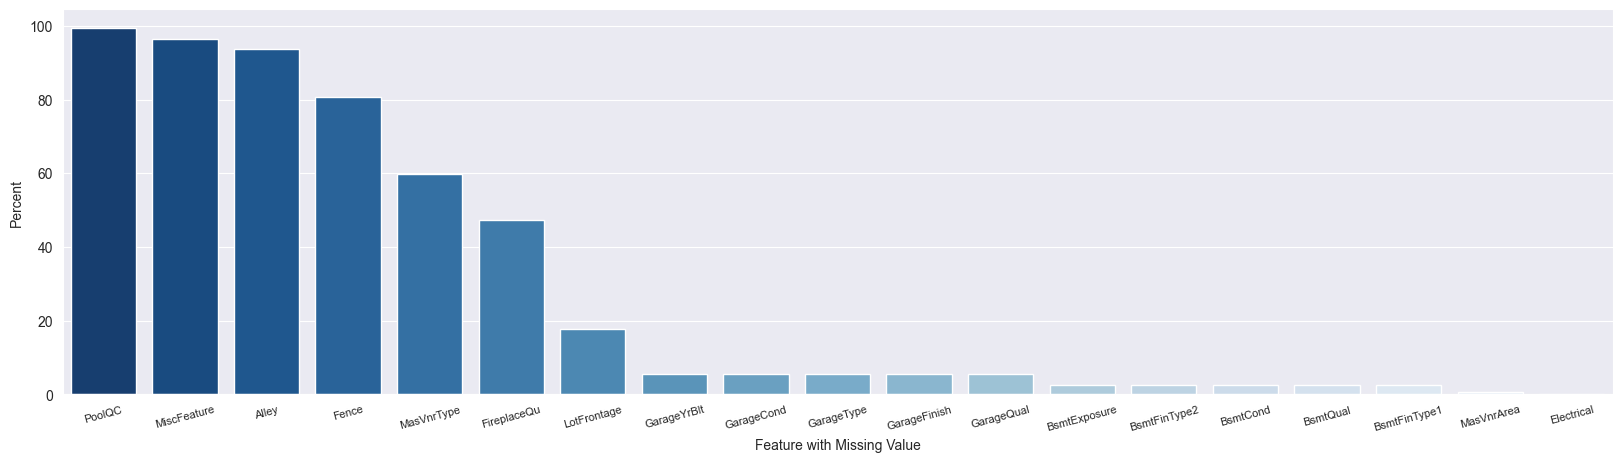

In [965]:
# 可视化
import matplotlib.pyplot as plt
import seaborn as sns

missing = pd.concat([(df.isnull().sum().sort_values(ascending=False) / len(df) * 100)], 
                    axis=1, 
                    keys=['Percent'])

# 仅展示存在缺失信息的相关列信息
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing[missing['Percent']>0].index, y='Percent', data=missing[missing['Percent']>0], palette='Blues_r')
plt.xticks(rotation=15, size=8)
plt.xlabel("Feature with Missing Value")

missing[missing['Percent']>0].T.style.background_gradient(cmap='Blues', axis=1)

从表格和柱状图不难看出：

- 部分列的数据缺失非常严重（其中 `PoolQC`, `MiscFeature` 字段缺失度已达 95%）

- 其中，缺失度超过 50% 的特征共计 5 个：`"PoolQC", "MiscFeature", "Alley", "Fence", "MasVnrType"`，直接丢弃


In [966]:
df = df.drop(["PoolQC", "MiscFeature", "Alley", "Fence", "MasVnrType"], axis=1)

根据 `data_description.txt` 中的描述，我们按照以下规则对不同字段的数据进行补全：

1. `NAN` 表示该房产不具备相应设施 => 使用 `None` 进行填充
    
    > "Fence" = NA 表明该房产没有篱笆

2. `NAN` 表示对应数据为 0 => 使用 `0` 进行填充
    
    > "BsmtFullBath" = NAN 表明该房产地下室中有 0 个完整浴室
    
3. `NAN` 确实表示数据缺失 => 使用**出现频率最高的值**进行填充

In [967]:
nones = ['FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for col in nones:
    df[col].fillna('None', inplace=True)

zeros = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea']
for col in zeros:
    df[col].fillna(0, inplace=True)

freqs = ['Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual', 'SaleType', 'Utilities']
for col in freqs:
    df[col].fillna(df[col].mode()[0], inplace=True)

以下两个特征无法通过简单规则进行填充，此处进行舍弃：

- `MSZoning` 房屋所处的区域类型（农业/商业/...）

- `LotFrontage` 房屋临近的街道信息

In [968]:
df = df.drop(["MSZoning", "LotFrontage"], axis=1)
numerical_col = df.select_dtypes(exclude=['object']).columns

### 2.2 Outlier 离群点处理

房价 `SalePrice` 随各数值类型特征的线性回归图（四次曲线拟合）如下：

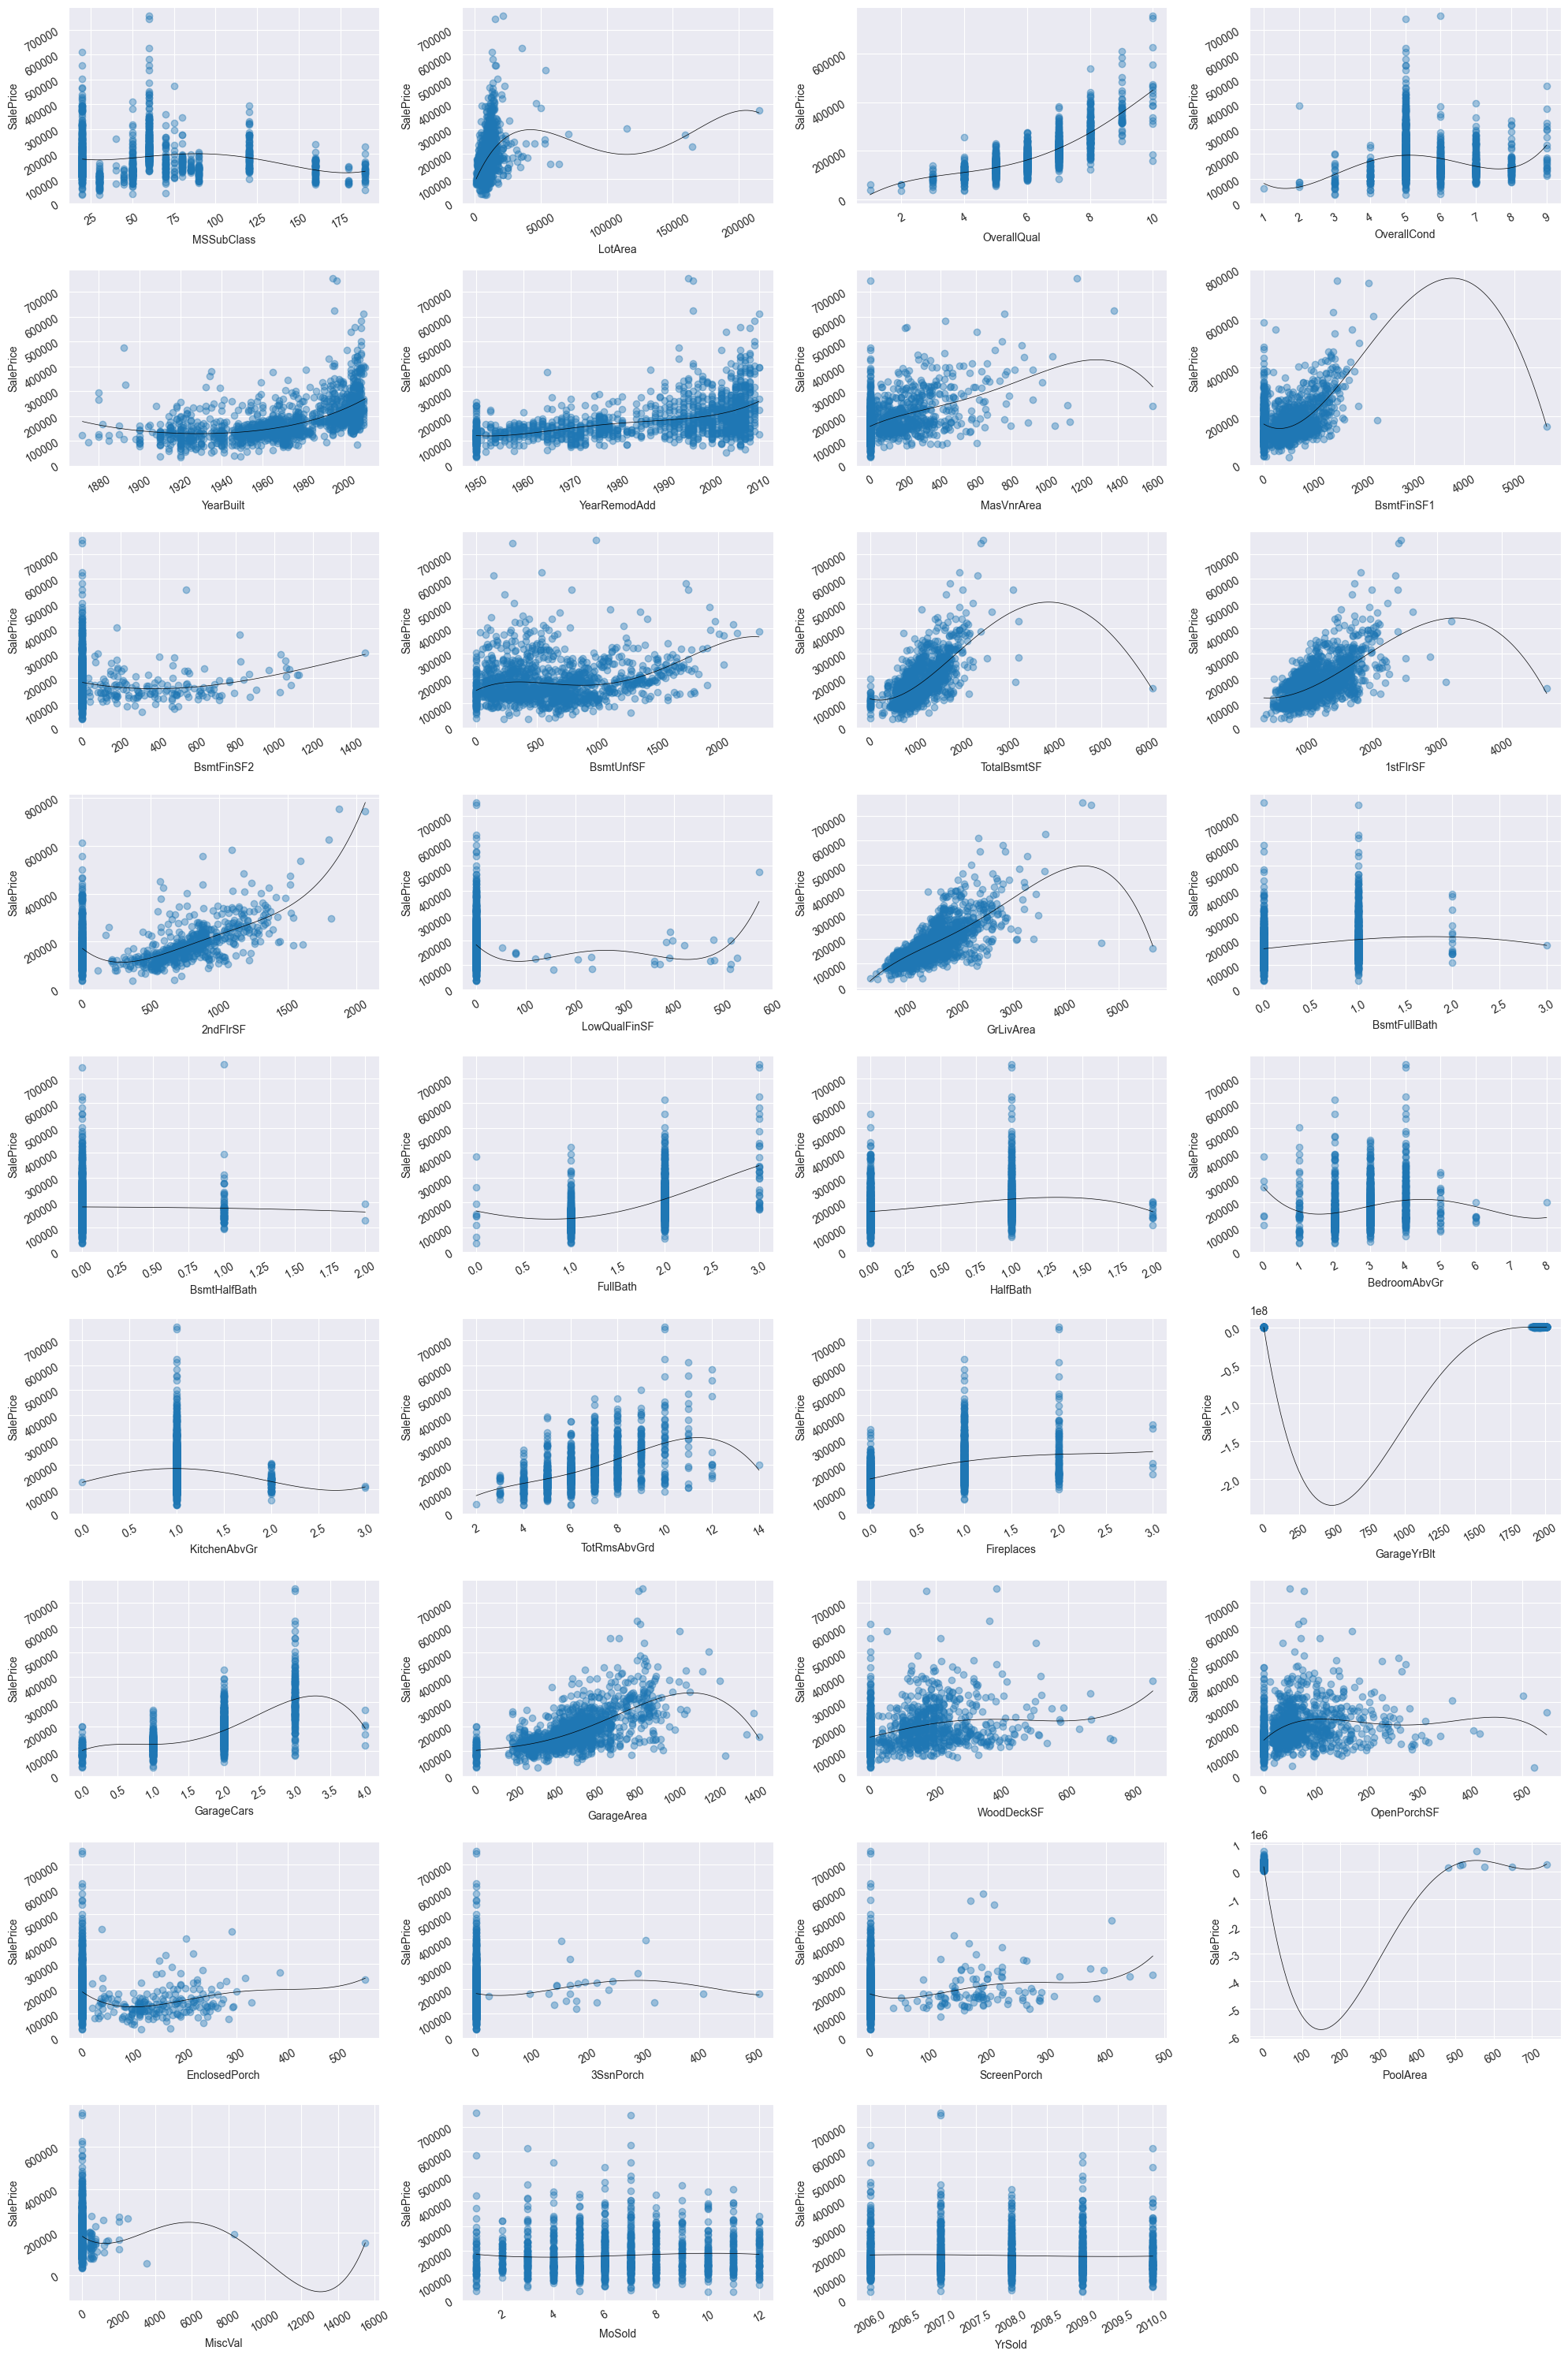

In [969]:
plt.figure(figsize=(20,30))

for i in range(0, numerical_col.size-1):
    ax = plt.subplot(9,4, i+1)
    sns.regplot(x=df[numerical_col[i]],
                y=df['SalePrice'],
                ax=ax,
                order=4,
                ci=None,
                line_kws={
                    'color': 'black',
                    'lw': '0.5'
                },
                scatter_kws={'alpha':0.4})
    ax.tick_params(labelrotation=30)

plt.tight_layout()

各数值类型特征的箱线图如下：

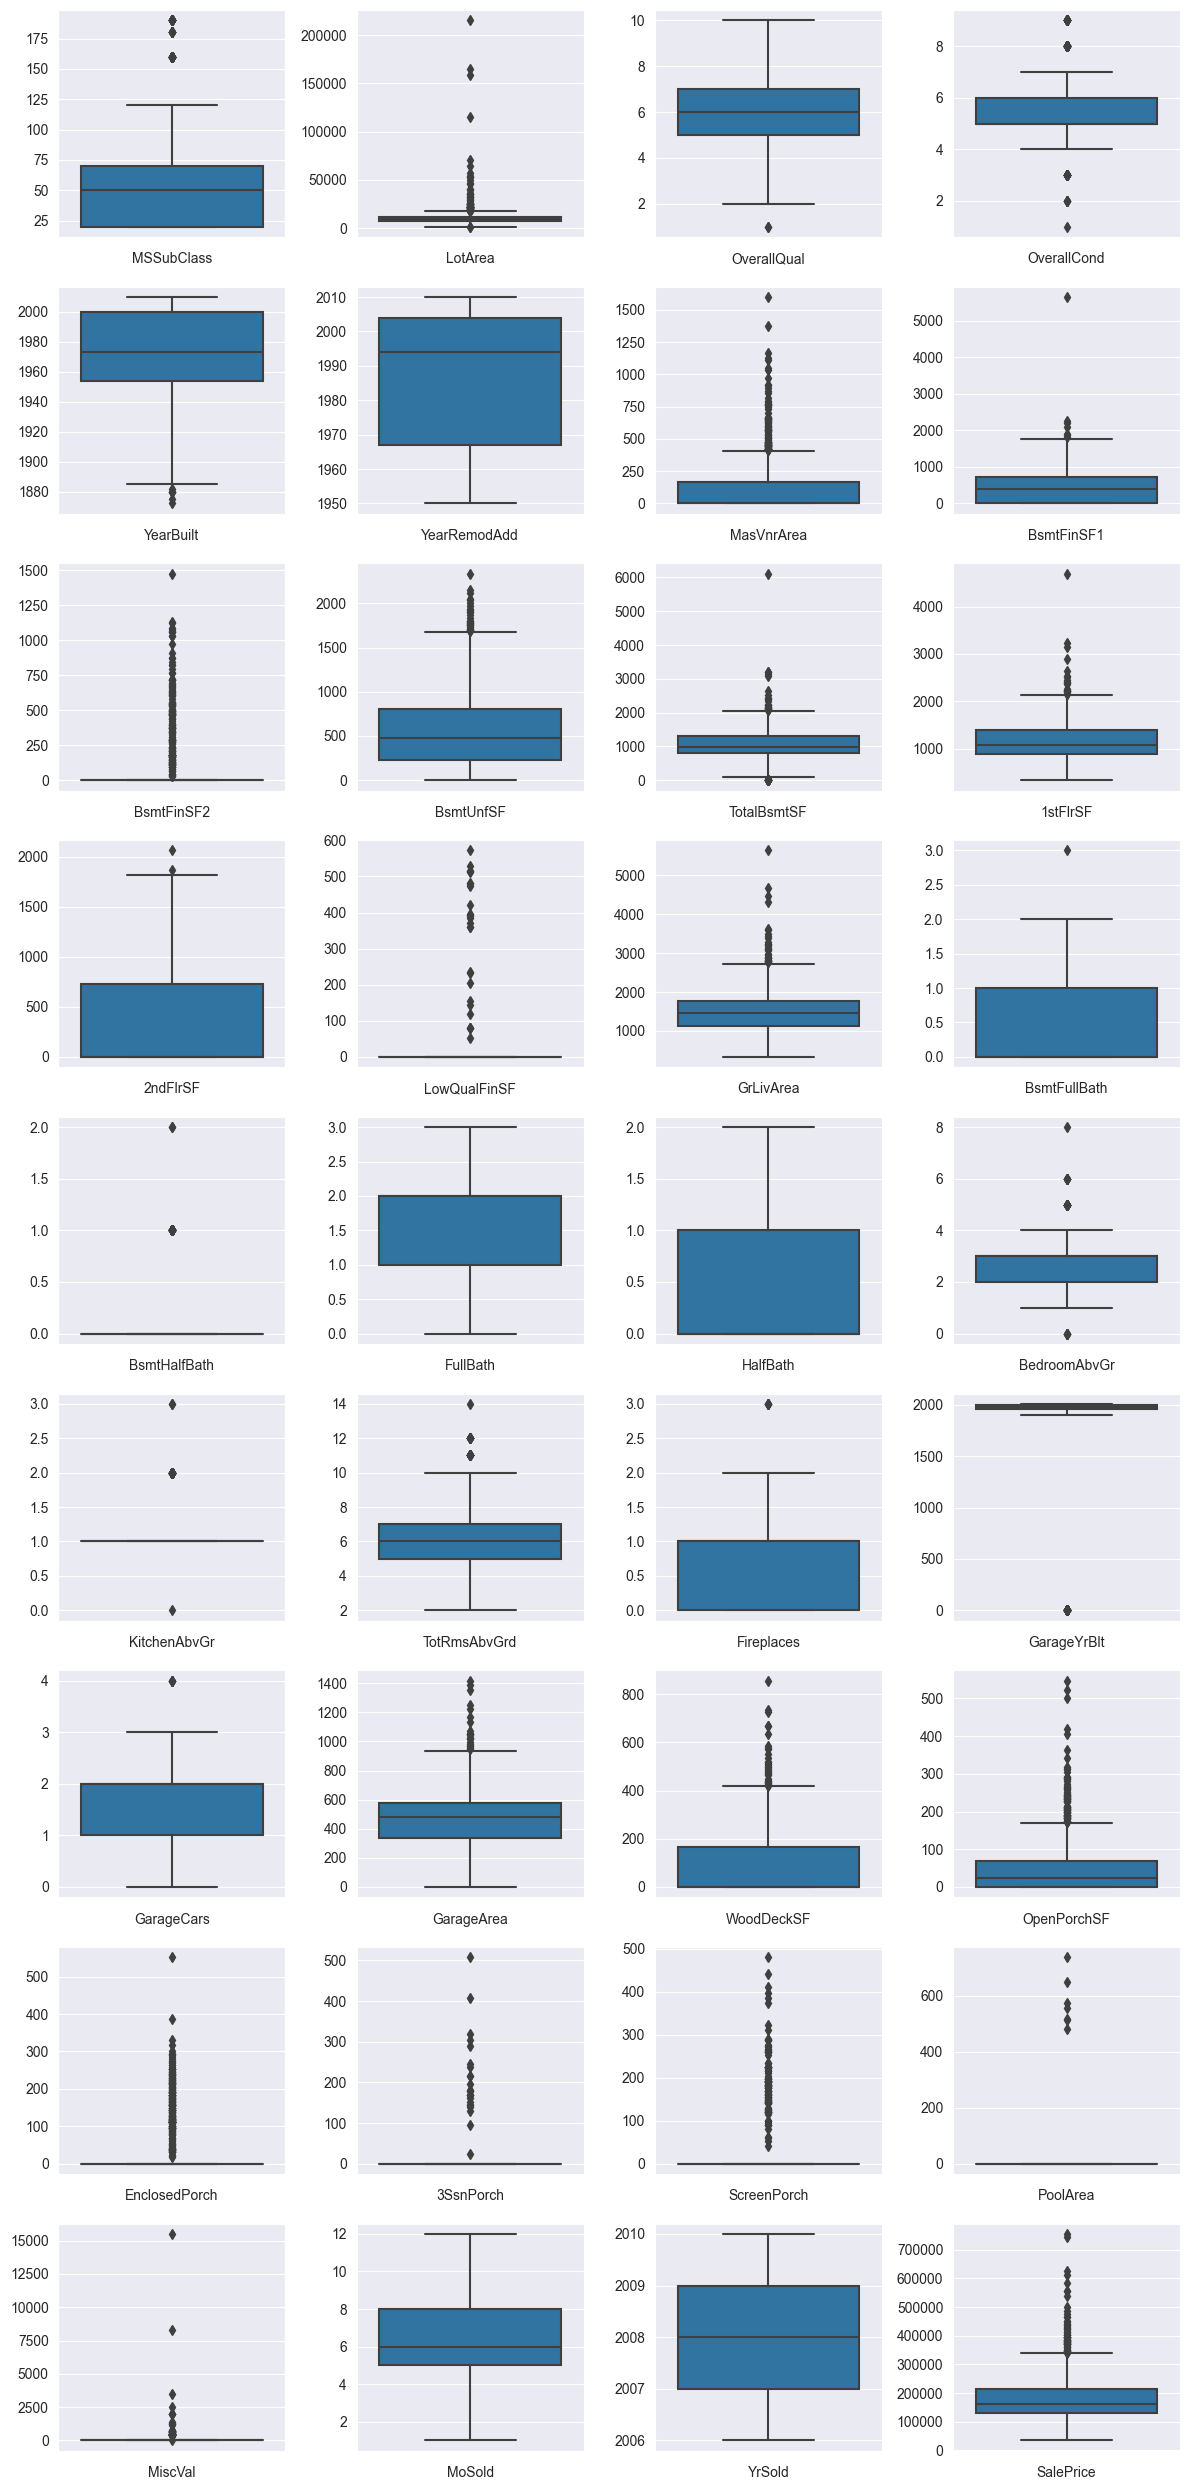

In [970]:
plt.figure(figsize=(12,25))
for i in range(0, numerical_col.size):
    ax = plt.subplot(9,4, i+1)
    sns.boxplot(y=df[numerical_col[i]],
                ax=ax)
    ax.set_ylabel("")
    ax.set_xlabel(numerical_col[i])
    
plt.tight_layout()

此处以 $ \left| zscore \right| = \left| \frac{x - \mu}{\sigma} \right| > 3 $ 作为 `outlier` 的判断依据：

- 通过对箱线图的观察，此处选择对 `"GrLivArea", "TotalBsmtSF", "YearBuilt", "YearRemodAdd"` 四个特征进行离群点检测与移除处理

- 同时，对回归目标 `SalePrice` 中的极端值进行处理

In [971]:
to_detect = [ 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd', 'SalePrice']

# detect outlier
outliers = set()

for col in to_detect:
    outliers.update((df[col][abs((df[col] - df[col].mean()) / df[col].std()) > 3]).index) # abs(zscore) > 3

outliers = list(outliers)
print("共发现", len(outliers), "条包含离群点的记录")

# remove outlier
df = df.drop(outliers, axis = 0)

共发现 39 条包含离群点的记录


### 2.3 Categorial 类特征转数字编码

由于：

- `lasso` 与 `support vector` 模型不支持 `object/string` 类型数据

- 转换可以降低数据存储成本

此处将 `categorial` 类型特征值 (`string`) 转换为对应的类型编号 (`int`)。

In [972]:
nums = df.select_dtypes(exclude=['object'])
# 待转换特征
categorical_col = df.select_dtypes(include='object').columns

for i in range(0, categorical_col.size):
    map = {} 
    idx = 0
    # 建立 取值 -> 编号 的映射
    for type in df[categorical_col[i]].unique():
        map[type] = idx
        idx += 1
    # 根据映射关系对该特征值进行替换
    df[categorical_col[i]] = df[categorical_col[i]].map(map).astype('int')


## 3 Feature Engineering 

### 3.1 Feature Selection 特征选取

各数值类型特征间的协方差矩阵如下图所示：

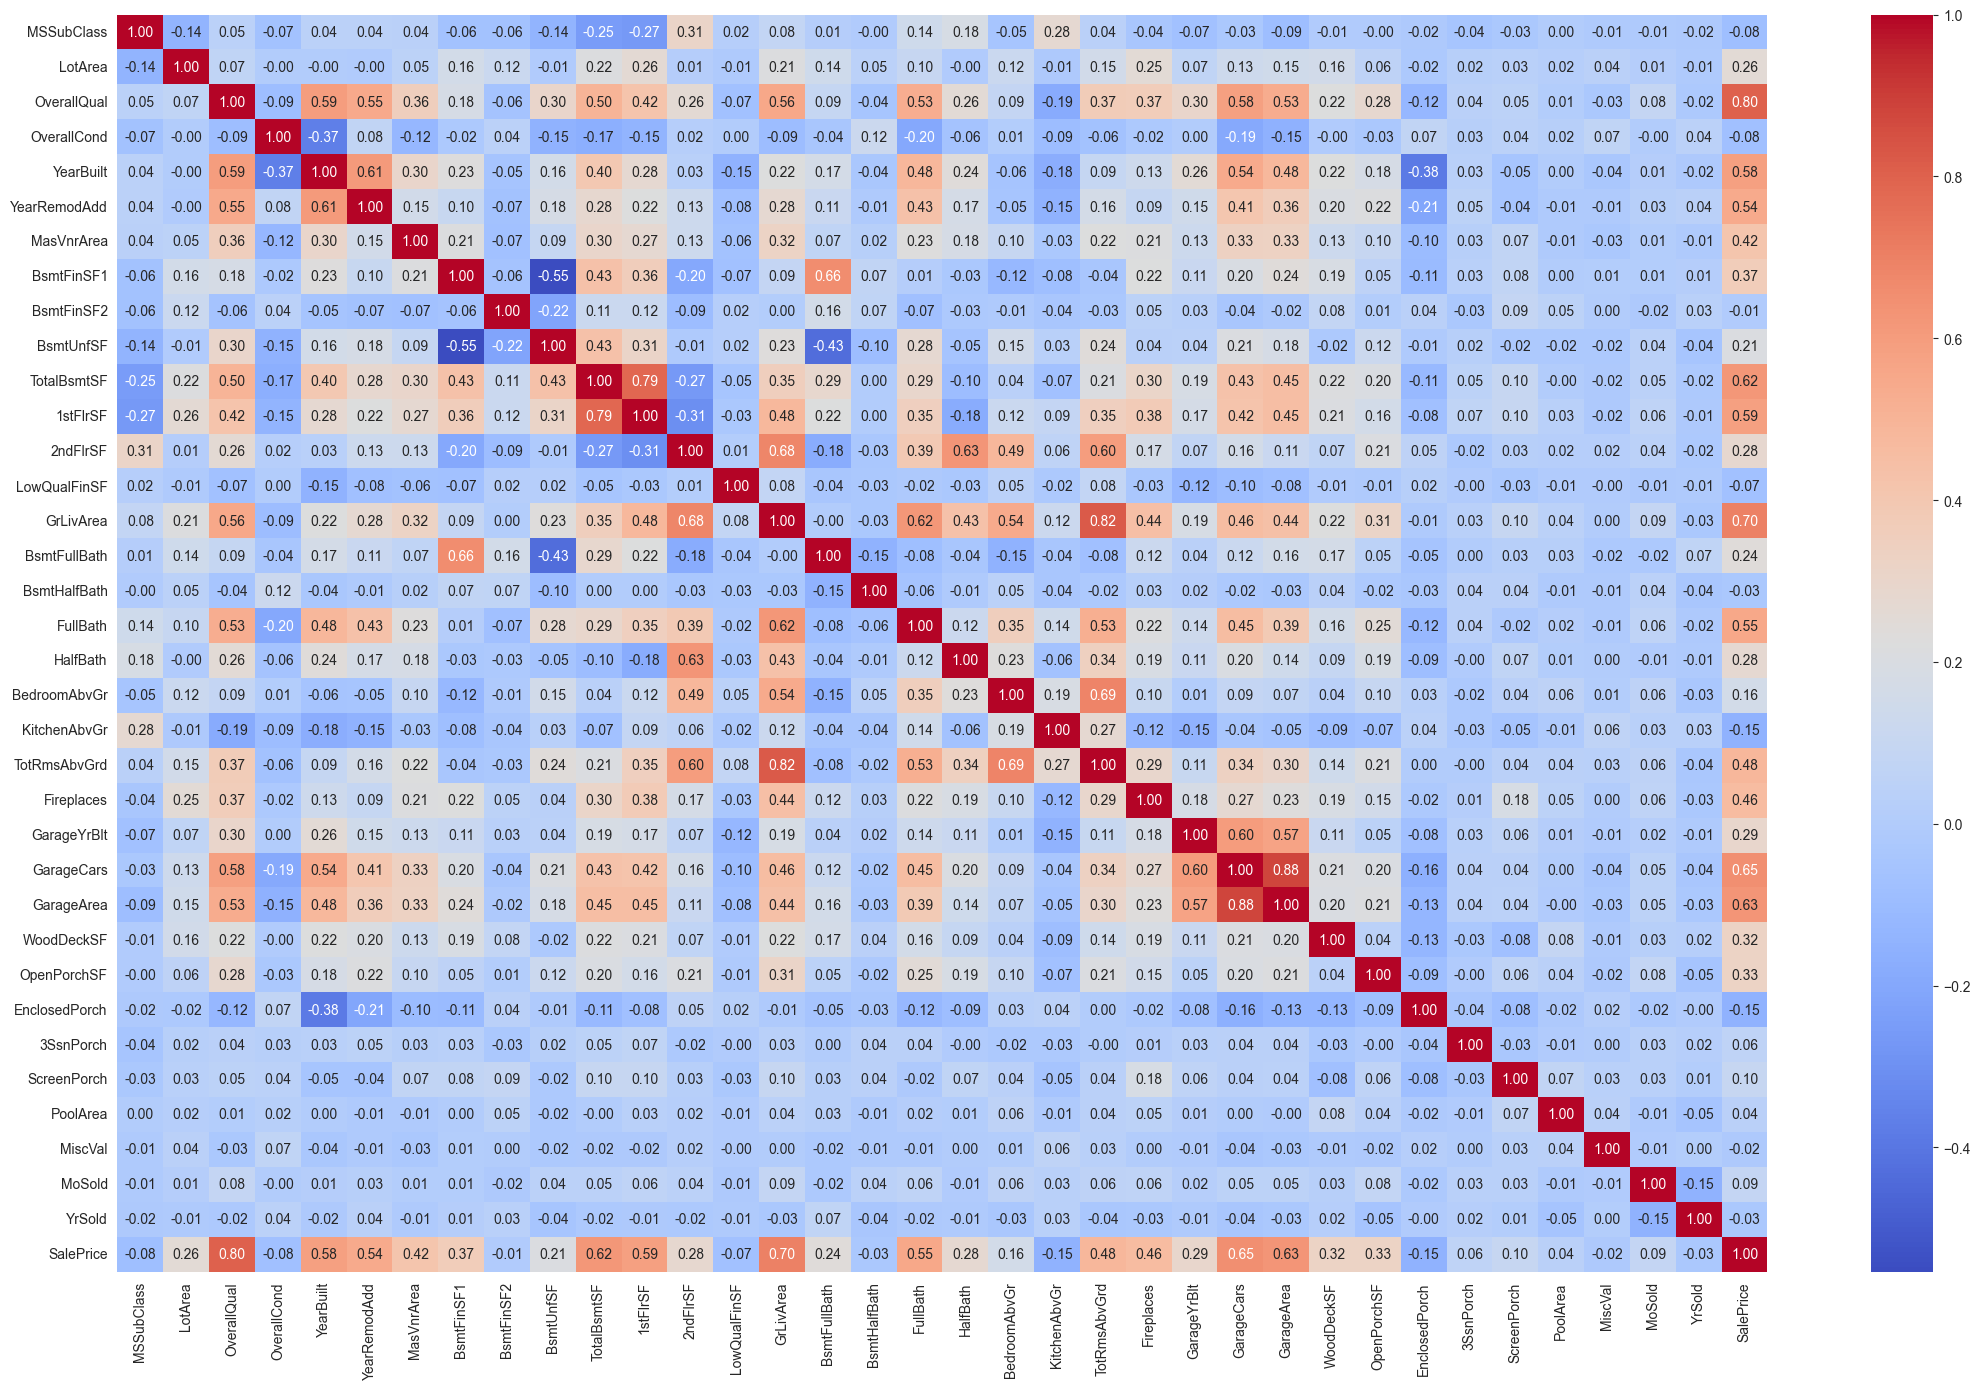

In [973]:
plt.figure(figsize=(22, 14))
sns.heatmap(nums.corr(), 
            cmap='coolwarm',
            fmt='.2f',
            annot=True)
plt.tight_layout()

下面对强相关特征对进行筛选：

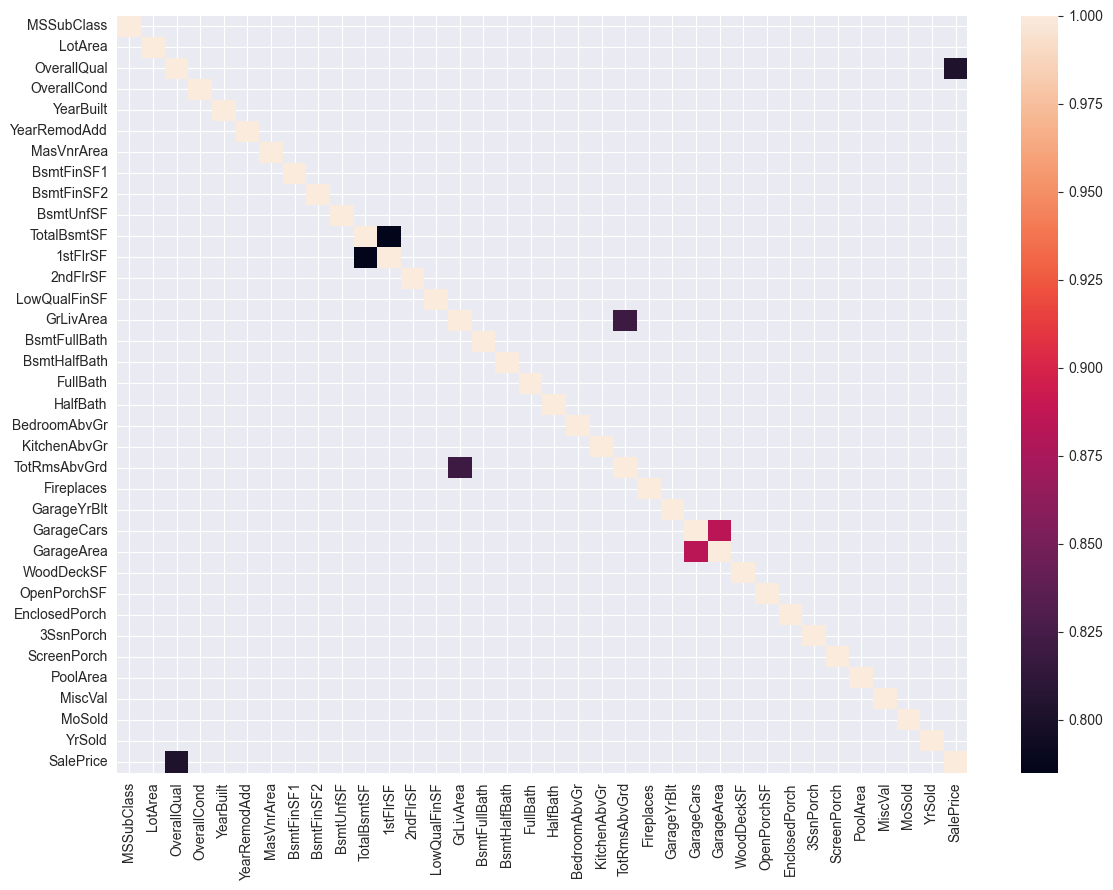

In [974]:
plt.figure(figsize=(12,9))
corr_matrix = nums.corr()
sns.heatmap(corr_matrix,
            mask = corr_matrix < 0.75)
plt.tight_layout()

观察上图可知，目前存在四对强相关特征：

| No. | df 1 | Feature 2 |
| :-: | :-: | :-: |
| 1 | OverallQual | SalePrice |
| 2 | TotRmsAbvGrd | GrLivArea |
| 3 | 1stFlrSF | TotalBsmtSF |
| 4 | GarageArea | GarageCars |

此处直接删除特征 "GarageCars"（其余特征会在后续操作中涉及）

In [975]:
df=df.drop(["GarageCars"], axis=1)

### 3.2 Merge & Creation

此部分工作如下：

- 对一些特征进行合并，随后删除其中部分内容

    - 对部分设施的总量进行统计（总面积/总房间数）

    - 对描述同一部分的 `Qual` 与 `Cond` 特征进行合并

- 创造一些新的特征用于反映房产某一方面的总体质量

In [976]:
# 1 合并特征

# 门廊总面积
df['TotPorchSF'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF'])
# 房屋总面积
df['TotSF']      = (df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF'] + df['TotPorchSF'])
# 总浴室数量
df['TotBath']    = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
# 外部环境总质量
df['TotExtQual']  = (df['ExterQual'] + df['ExterCond'])
# 地下室总质量
df['TotBsmtQual'] = (df['BsmtQual'] + df['BsmtCond'] + df['BsmtFinType1'] + df['BsmtFinType2'] + df['BsmtExposure'])
# 车库总质量
df['TotGrgQual']  = (df['GarageQual'] + df['GarageCond'] + df['GarageFinish'])
# 整体质量
df['TotQual']     = (df['OverallQual'] + df['OverallCond'] + 
                     df['TotExtQual'] + df['TotBsmtQual'] + df['TotGrgQual'] + 
                     df['KitchenQual'] + df['HeatingQC'] + df['FireplaceQu'] + df['CentralAir'])

# 2 创建特征

# 总体质量
df['Qual']       = df['TotQual'] * df['GrLivArea']
# 地下室质量
df['QualBsm']    = df['TotBsmtQual'] * (df['BsmtFinSF1'] + df['BsmtFinSF2'])
# 门廊质量
df['QualPorch']  = df['TotExtQual'] * df['TotPorchSF']
# 车库质量
df['QualGrg']    = df['TotGrgQual'] * df['GarageArea']
# 生活区质量
df['QlLivArea']  = (df['GrLivArea'] - df['LowQualFinSF']) * (df['TotQual'])
# 壁炉质量
df['QualFirepl'] = df['FireplaceQu'] * df['Fireplaces']
# 是否翻修
df['Remoded']    = (df['YearRemodAdd'] != df['YearBuilt']).apply(lambda x: 1 if x == True else 0)
# 周边环境质量
df['QualExt']    = (df['TotExtQual'] * (df['Exterior1st'] + df['Exterior2nd']) * df['MasVnrArea'])

删除可被其他特征描述的列（如 `Utilities` ）和 与目标值低相关的特征（如 `Yr/MoSold` ）：

In [977]:
df = df.drop(
        [   
            # 可用其他特征描述
            'ExterQual', 'LowQualFinSF',
            'Utilities', 'KitchenQual', 'HeatingQC', 'FireplaceQu', 'MiscVal', 
            'BsmtFinType2', 'BsmtQual', 'GarageQual', 'GarageFinish',
            # 低相关
            'YrSold', 'MoSold', 'PoolArea',
        ], 
        axis=1
    )

## 4 Modeling & Validation 建模与验证

在训练集上（使用默认参数）训练以下四种回归模型并对其性能进行五折交叉验证对比：

1. 线性(Linear)回归模型：Lasso & Ridge

2. 支持向量(Support Vector)回归模型

3. 梯度提升(Gradient Boosting)模型：XGBoost
    
4. 随机森林(Random Forest)模型

In [978]:
# models
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# k-fold
from sklearn.model_selection import cross_validate, KFold
kf = KFold(n_splits=5, random_state=30, shuffle=True)

# trainSet
price = df['SalePrice']
feature = df.drop(['SalePrice'], axis=1)

# robustScaler
from sklearn.preprocessing import RobustScaler
robust_feature = RobustScaler().fit_transform(feature)

In [979]:
# default
lasso      = LassoCV(cv=kf)
ridge      = RidgeCV(cv=kf)
svr        = SVR()
xgb        = XGBRegressor()
randforest = RandomForestRegressor()

models = [lasso, ridge, svr, xgb, randforest]
labels = ['Lasso', 'Ridge', 'SVR', 'XGBoost', 'RandForest']

此处定义 `validate()` 函数用于对指定的一系列模型性能进行 k 折交叉（由参数 `kf` 决定）验证评估：

- 参数 `f(feature), p(price)` 用于指定输入的训练集，可以通过修改查看其对训练结果的影响

- 函数最终返回由性能指标与回归模型名称构成的表格

    > 回归模型的常见评价指标有：
    >
    > - 解释方差 `Explained Variance`
    > 
    > - 平均绝对误差 `Mean Absolute Error(MAE)` 与 平均绝对百分比误差 `Mean Absolute Percentage Error(MAPE)`
    > 
    > - 均方误差 `Mean Squared Error(MSE)` 与 均方根误差 `Root Mean Squared Error(RMSE)`
    > 
    > - 可决系数 $ R^2 $

    此处选用 `RMSE`, `MAPE` 与训练用时 (`Fit Time`) 三个指标对各模型训练结果进行对比

In [980]:
def validate(models, f, p, kf):
    table = pd.DataFrame()
    
    for i in range(0, len(models)):
        m = models[i]
        l = labels[i]
        table.loc[i, 'Model'] = l
        validation = cross_validate(
                        m,                                                  # 本轮判断的模型
                        f, p, cv=kf,
                        scoring=['neg_root_mean_squared_error',             # 均方误差
                                 'neg_mean_absolute_percentage_error'],     # 平均绝对百分比误差
                        n_jobs=-1                                           # 使用所有处理器
                    )
        table.loc[i, 'RMSE']     =    -validation['test_neg_root_mean_squared_error'].mean()
        table.loc[i, 'MAPE(%)']  = abs(validation['test_neg_mean_absolute_percentage_error'].mean())*100
        table.loc[i, 'Fit Time'] =     validation['fit_time'].mean()

    return table

### 4.1 初步训练

In [981]:
# 标准化数据
print("RobustScaled:")
norm = validate(models, robust_feature, price, kf)
display(norm.style.background_gradient(cmap='Blues'))

# 未标准化数据
print("未标准化数据:")
raw = validate(models, feature, price, kf)
display(raw.style.background_gradient(cmap='Blues'))

RobustScaled:


,Model,RMSE,MAPE(%),Fit Time
0,Lasso,32550.154174,14.004408,0.031409
1,Ridge,23314.299548,10.727888,0.021724
2,SVR,67892.186872,30.699774,0.061441
3,XGBoost,22933.139724,9.648048,0.426059
4,RandForest,23334.381994,9.955878,1.204454


未标准化数据:


,Model,RMSE,MAPE(%),Fit Time
0,Lasso,33117.227332,15.174546,0.091484
1,Ridge,23394.837471,10.745984,0.070939
2,SVR,67868.521404,30.687205,0.074107
3,XGBoost,22940.535581,9.652616,0.438498
4,RandForest,23220.791103,9.924912,1.154290


观察以上两个表格，可以得出以下结论：

1. 在预测质量方面，$ XGBoost \approx RandForest > Ridge > Lasso > SVR $ ，总体预测误差 $ \geq 10% $ 并不理想

2. 在训练时间方面，`RandForest > Ridge, Lasso, SVR > XGBoost`

=> 总体来看，`XGBoost` 回归模型的效果较好

3. 线性回归模型 (`lasso & ridge`)

    - 受 `outlier` 影响较大

        由于 2.2 中无法筛除所有离群点，此处使用 `RobustScaler` 对 feature 进行放缩以再度降低 `outlier` 对模型的影响

        对比两表可发现这一操作对两个线性回归模型的预测结果与训练时间有相对明显的优化（其余模型无显著变化）

    - 在此训练集下，`ridge` 性能优于 `lasso`（抗扰动能力更强）
    

### 4.2 优化尝试

查看预测目标 `SalePrice` 的具体分布情况：

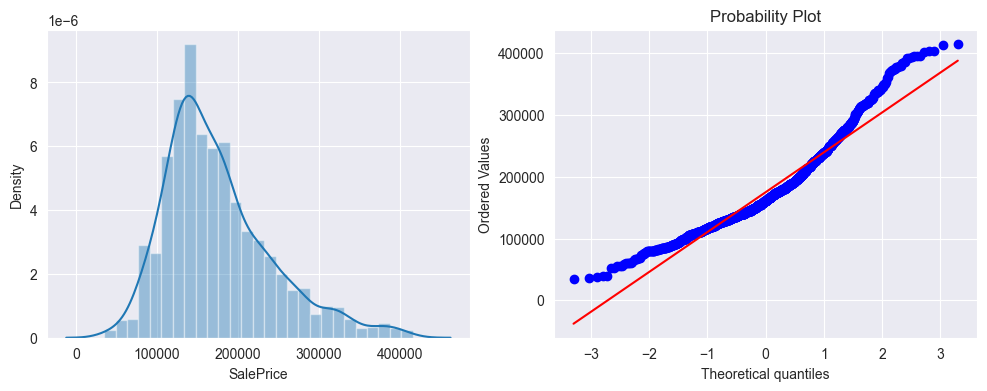

In [982]:
from scipy import stats
sns.set_style('darkgrid')

fig = plt.figure(figsize=(12, 4))
sns.distplot(price, ax=plt.subplot(1, 2, 1))
stats.probplot(price, plot=plt.subplot(1, 2, 2))
plt.show()

从 直方图 和 PP图 中不难看出 `SalePrice` 的分布和正态分布存在一定差异（存在一定的偏度）：

由于大多数机器学习模型对于正态分布的数据有更好的预测效果，此处尝试使用 `log1p()` 函数对其进行处理，使其更符合正态分布。

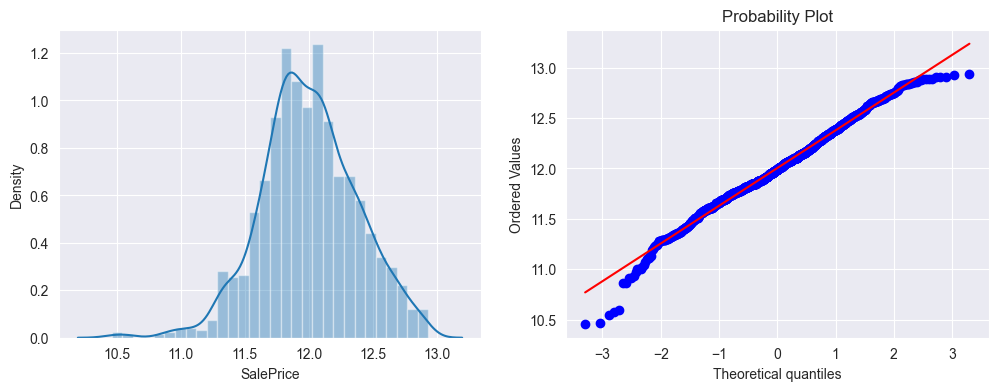

In [983]:
import numpy as np

# transform
df = np.log1p(df)

# new trainSet
price = df['SalePrice']
feature = df.drop(['SalePrice'], axis=1)

# display
fig = plt.figure(figsize=(12, 4))
sns.distplot(price, ax=plt.subplot(1, 2, 1))
stats.probplot(price, plot=plt.subplot(1, 2, 2))
plt.show()


至少从 PP图 来看，处理后的 `SalePrice` 更加符合正态分布了 => 但最终预测结果应为 `exp(pred)`

下面在处理后的训练集上重新训练模型：

In [984]:
raw = validate(models, feature, price, kf)
display(raw.style.background_gradient(cmap='Blues'))

,Model,RMSE,MAPE(%),Fit Time
0,Lasso,0.127971,0.769882,0.093329
1,Ridge,0.126334,0.756148,0.055127
2,SVR,0.146894,0.871671,0.033705
3,XGBoost,0.133963,0.786981,0.411583
4,RandForest,0.136409,0.787389,1.220273


将上表与 4.1 中得到的结果进行对比，可以发现各模型的预测精度有了较大提升。